In [23]:
import json
import getpass
import requests
import numpy as np
import geopandas as gpd
import zipfile
import io
import matplotlib.pyplot as plt
from pprint import pprint
from osgeo import gdal
from shapely.geometry import box
from pathlib import Path

# Login to NASA Earthdata

In [24]:
nasa_earthdata_api = 'https://appeears.earthdatacloud.nasa.gov/api/'

nasa_earthdata_user = getpass.getpass(prompt = 'Enter NASA Earthdata Login Username: ')      
nasa_earthdata_password = getpass.getpass(prompt = 'Enter NASA Earthdata Login Password: ') 

token_response = requests.post(f"{nasa_earthdata_api}login", auth=(nasa_earthdata_user, nasa_earthdata_password)).json()
del nasa_earthdata_user, nasa_earthdata_password

# Explore Products

In [25]:
product_response = requests.get(f"{nasa_earthdata_api}product").json()                         # request all products in the product service
print(f"AppEEARS currently supports {len(product_response)} products.") 
products = {p['ProductAndVersion']: p for p in product_response}

AppEEARS currently supports 149 products.


# Show All Products with Description Containing Keyword

In [26]:
def get_products_with_description(keyword):
    for p in {p['ProductAndVersion'] for p in product_response}:                                            
        if keyword in products[p]['Description']:
            pprint(products[p])

## Vegetation
Below is all products with a description that contains the keyword "Vegetation"

In [5]:
get_products_with_description(keyword='Vegetation')

{'Available': True,
 'DOI': '10.5067/VIIRS/VNP13A3.001',
 'Deleted': False,
 'Description': 'Vegetation Indices (NDVI & EVI)',
 'DocLink': 'https://doi.org/10.5067/viirs/vnp13a3.001',
 'Info': {},
 'Platform': 'Suomi NPP VIIRS',
 'Product': 'VNP13A3',
 'ProductAndVersion': 'VNP13A3.001',
 'RasterType': 'Tile',
 'Resolution': '1000m',
 'Source': 'LP DAAC',
 'TemporalExtentEnd': 'Present',
 'TemporalExtentStart': '2012-01-01',
 'TemporalGranularity': 'Monthly',
 'Version': '001'}
{'Available': True,
 'DOI': '10.5067/VIIRS/VNP13A2.001',
 'Deleted': False,
 'Description': 'Vegetation Indices (NDVI & EVI)',
 'DocLink': 'https://doi.org/10.5067/viirs/vnp13a2.001',
 'Info': {},
 'Platform': 'Suomi NPP VIIRS',
 'Product': 'VNP13A2',
 'ProductAndVersion': 'VNP13A2.001',
 'RasterType': 'Tile',
 'Resolution': '1000m',
 'Source': 'LP DAAC',
 'TemporalExtentEnd': 'Present',
 'TemporalExtentStart': '2012-01-17',
 'TemporalGranularity': '16 day',
 'Version': '001'}
{'Available': True,
 'DOI': '10.506

## Elevation
Below is all products with a description that contains the keyword "Elevation"

In [6]:
get_products_with_description(keyword='Elevation')

{'Available': True,
 'DOI': '10.5067/MEaSUREs/SRTM/SRTMGL1_NC.003',
 'Deleted': False,
 'Description': 'Elevation (DEM)',
 'DocLink': 'https://doi.org/10.5067/MEaSUREs/SRTM/SRTMGL1_NC.003',
 'Info': {},
 'Platform': 'SRTM',
 'Product': 'SRTMGL1_NC',
 'ProductAndVersion': 'SRTMGL1_NC.003',
 'RasterType': 'Tile',
 'Resolution': '30m',
 'Source': 'LP DAAC',
 'TemporalExtentEnd': '2000-02-21',
 'TemporalExtentStart': '2000-02-11',
 'TemporalGranularity': 'Static',
 'Version': '003'}
{'Available': True,
 'DOI': '10.5067/MEaSUREs/NASADEM/NASADEM_NC.001',
 'Deleted': False,
 'Description': 'Elevation',
 'DocLink': 'https://doi.org/10.5067/MEaSUREs/NASADEM/NASADEM_NC.001',
 'Info': {},
 'Platform': 'NASADEM',
 'Product': 'NASADEM_NC',
 'ProductAndVersion': 'NASADEM_NC.001',
 'RasterType': 'Tile',
 'Resolution': '30m',
 'Source': 'LP DAAC',
 'TemporalExtentEnd': '2/21/2000',
 'TemporalExtentStart': '2/11/2000',
 'TemporalGranularity': 'Static',
 'Version': '001'}
{'Available': True,
 'DOI': '10

# Weather

In [28]:
get_products_with_description(keyword='Weather')

{'Available': True,
 'DOI': '10.3334/ORNLDAAC/2129',
 'Deleted': False,
 'Description': 'Daily Surface Weather Data for North America',
 'DocLink': 'https://doi.org/10.3334/ORNLDAAC/2129',
 'Info': {},
 'Platform': 'DAYMET',
 'Product': 'DAYMET',
 'ProductAndVersion': 'DAYMET.004',
 'RasterType': 'Tile',
 'Resolution': '1000m',
 'Source': 'ORNL',
 'TemporalExtentEnd': '2023-12-31',
 'TemporalExtentStart': '1950-01-01',
 'TemporalGranularity': 'Daily',
 'Version': '004'}


# Select Products

In [29]:
selected_products = [products['MOD13Q1.061'], products['SRTMGL1_NC.003'], products['DAYMET.004']]
print("Selected products: ")
pprint(selected_products)

Selected products: 
[{'Available': True,
  'DOI': '10.5067/MODIS/MOD13Q1.061',
  'Deleted': False,
  'Description': 'Vegetation Indices (NDVI & EVI)',
  'DocLink': 'https://doi.org/10.5067/MODIS/MOD13Q1.061',
  'Info': {},
  'Platform': 'Terra MODIS',
  'Product': 'MOD13Q1',
  'ProductAndVersion': 'MOD13Q1.061',
  'RasterType': 'Tile',
  'Resolution': '250m',
  'Source': 'LP DAAC',
  'TemporalExtentEnd': 'Present',
  'TemporalExtentStart': '2000-02-18',
  'TemporalGranularity': '16 day',
  'Version': '061'},
 {'Available': True,
  'DOI': '10.5067/MEaSUREs/SRTM/SRTMGL1_NC.003',
  'Deleted': False,
  'Description': 'Elevation (DEM)',
  'DocLink': 'https://doi.org/10.5067/MEaSUREs/SRTM/SRTMGL1_NC.003',
  'Info': {},
  'Platform': 'SRTM',
  'Product': 'SRTMGL1_NC',
  'ProductAndVersion': 'SRTMGL1_NC.003',
  'RasterType': 'Tile',
  'Resolution': '30m',
  'Source': 'LP DAAC',
  'TemporalExtentEnd': '2000-02-21',
  'TemporalExtentStart': '2000-02-11',
  'TemporalGranularity': 'Static',
  'Ver

# Explore Product Layers

In [30]:
for selected_product in selected_products:
    selected_product_layers = requests.get(f"{nasa_earthdata_api}product/{selected_product['ProductAndVersion']}").json()
    print(f"{selected_product['ProductAndVersion']} Layer ")
    pprint(list(selected_product_layers.keys()))

MOD13Q1.061 Layer 
['_250m_16_days_EVI',
 '_250m_16_days_MIR_reflectance',
 '_250m_16_days_NDVI',
 '_250m_16_days_NIR_reflectance',
 '_250m_16_days_VI_Quality',
 '_250m_16_days_blue_reflectance',
 '_250m_16_days_composite_day_of_the_year',
 '_250m_16_days_pixel_reliability',
 '_250m_16_days_red_reflectance',
 '_250m_16_days_relative_azimuth_angle',
 '_250m_16_days_sun_zenith_angle',
 '_250m_16_days_view_zenith_angle']
SRTMGL1_NC.003 Layer 
['SRTMGL1_DEM']
DAYMET.004 Layer 
['dayl', 'prcp', 'srad', 'swe', 'tmax', 'tmin', 'vp']


# Add Layers of Interest

In [32]:
layers = [
    ('MOD13Q1.061', '_250m_16_days_NDVI'),
    ('MOD13Q1.061', '_250m_16_days_EVI'),
    ('SRTMGL1_NC.003', 'SRTMGL1_DEM'),
    ('DAYMET.004', 'dayl'),
    ('DAYMET.004', 'prcp'),
    ('DAYMET.004', 'tmax'),
    ('DAYMET.004', 'tmin'),
    ('DAYMET.004', 'vp'),
]
products_layers = [{'layer': l[1], 'product': l[0]} for l in layers]
products_layers

[{'layer': '_250m_16_days_NDVI', 'product': 'MOD13Q1.061'},
 {'layer': '_250m_16_days_EVI', 'product': 'MOD13Q1.061'},
 {'layer': 'SRTMGL1_DEM', 'product': 'SRTMGL1_NC.003'},
 {'layer': 'dayl', 'product': 'DAYMET.004'},
 {'layer': 'prcp', 'product': 'DAYMET.004'},
 {'layer': 'tmax', 'product': 'DAYMET.004'},
 {'layer': 'tmin', 'product': 'DAYMET.004'},
 {'layer': 'vp', 'product': 'DAYMET.004'}]

# Explore Available Projections

In [33]:
projections = requests.get(f"{nasa_earthdata_api}spatial/proj").json()
pprint(projections)
projs = {}                                  
for p in projections: 
    projs[p['Name']] = p 
pprint(list(projs.keys()))

[{'Available': True,
  'Datum': '',
  'Description': '',
  'EPSG': '',
  'GridMapping': '',
  'LongName': 'Native Projection',
  'Name': 'native',
  'Platforms': '',
  'Proj4': '',
  'Units': ''},
 {'Available': True,
  'Datum': 'wgs84',
  'Description': '',
  'EPSG': 4326.0,
  'GridMapping': 'latitude_longitude',
  'LongName': 'Geographic',
  'Name': 'geographic',
  'Platforms': "['SRTM', 'ECOSTRESS', 'SSEBop ET', 'GPW', 'ASTER GDEM', "
               "'NASADEM', 'MEaSUREs LSTE', 'EMIT']",
  'Proj4': '+proj=longlat +datum=WGS84 +no_defs=True',
  'Units': 'degrees'},
 {'Available': True,
  'Datum': '',
  'Description': '',
  'EPSG': '',
  'GridMapping': 'sinusoidal',
  'LongName': 'MODIS Sinusoidal',
  'Name': 'sinu_modis',
  'Platforms': "['Combined MODIS', 'Terra MODIS', 'Aqua MODIS', 'Suomi NPP "
               "VIIRS', 'NOAA-20 VIIRS', 'Global WELD']",
  'Proj4': '+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +R=6371007.181 +units=m '
           '+no_defs=True',
  'Units': 'meters'},
 {'Availa

# Define Area of Interest

In [34]:
canada_boundary_shapefile_path = 'data/canada_boundary/lpr_000b16a_e.shp'

canada_boundary = gpd.read_file(canada_boundary_shapefile_path)
canada_boundary.head() 

,PRUID,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR,geometry
0,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,Newfoundland and Labrador,Terre-Neuve-et-Labrador,N.L.,T.-N.-L.,"MULTIPOLYGON (((8307365.589 2582136.711, 83083..."
1,11,Prince Edward Island / Île-du-Prince-Édouard,Prince Edward Island,Île-du-Prince-Édouard,P.E.I.,Î.-P.-É.,"MULTIPOLYGON (((8435711.754 1679935.966, 84358..."
2,12,Nova Scotia / Nouvelle-Écosse,Nova Scotia,Nouvelle-Écosse,N.S.,N.-É.,"MULTIPOLYGON (((8470851.646 1624745.011, 84710..."
3,13,New Brunswick / Nouveau-Brunswick,New Brunswick,Nouveau-Brunswick,N.B.,N.-B.,"MULTIPOLYGON (((8176224.537 1722553.46, 817623..."
4,24,Quebec / Québec,Quebec,Québec,Que.,Qc,"MULTIPOLYGON (((8399709.494 2261445.703, 84005..."


Number of coordinates : 3,390,960


<Axes: >

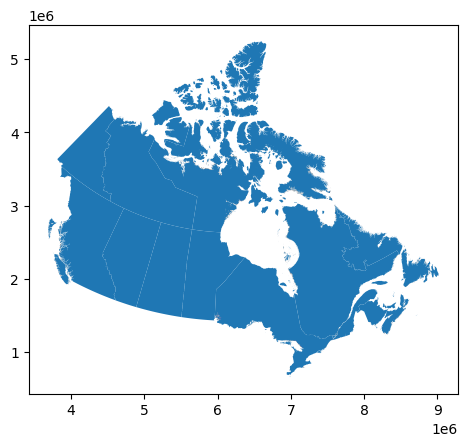

In [35]:
print(f"Number of coordinates : {canada_boundary.count_coordinates().sum():,}")
canada_boundary.plot()

# Reproject Area of Interest

Number of coordinates : 3,390,960


<Axes: >

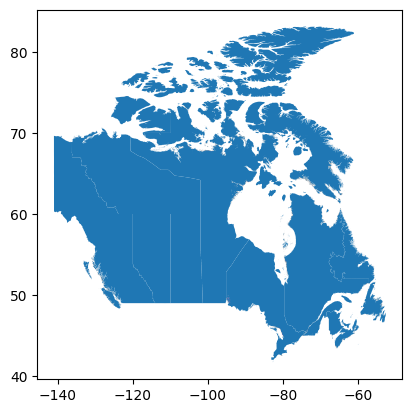

In [36]:
target_epsg = int(projs['geographic']['EPSG'])
canada_boundary = canada_boundary.to_crs(epsg=target_epsg)
print(f"Number of coordinates : {canada_boundary.count_coordinates().sum():,}")
canada_boundary.plot()

<Axes: >

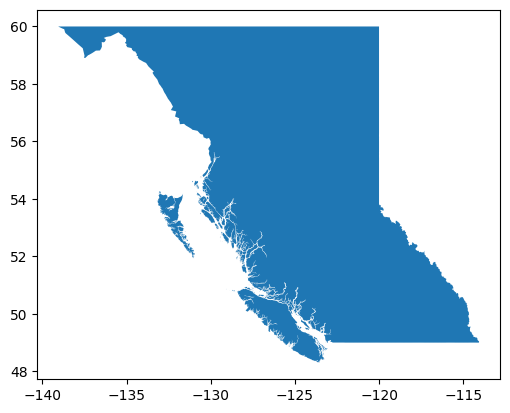

In [37]:
bc_boundary = canada_boundary[canada_boundary['PRUID'] == '59']
bc_boundary.plot()

# Grid Data

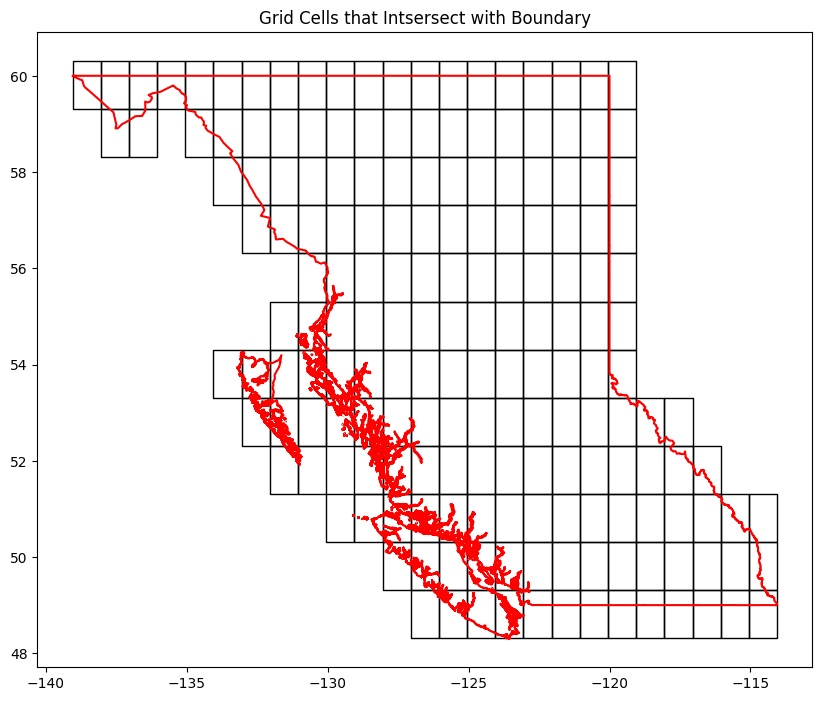

In [38]:
minx, miny, maxx, maxy = bc_boundary.total_bounds

grid_size = 1.0 

x_coords = np.arange(minx, maxx, grid_size)
y_coords = np.arange(miny, maxy, grid_size)
grid_cells = [box(x, y, x + grid_size, y + grid_size) for x in x_coords for y in y_coords]

grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs=bc_boundary.crs)
grid_within_boundary = grid[grid.intersects(bc_boundary.union_all())]

ax = grid_within_boundary.plot(edgecolor='black', facecolor='none', figsize=(10, 10))
bc_boundary.boundary.plot(ax=ax, edgecolor='red')
plt.title("Grid Cells that Intsersect with Boundary")
plt.show()

# Submit Task

In [44]:
geo_area_json = json.loads(grid_within_boundary.to_json())

In [45]:
task_name = input('Enter a Task Name: ')
task_type = "area" # 'area', 'point'
output_format = 'netcdf4' # 'netcdf4', 'geotiff'
output_projection = projs['geographic']['Name']
startDate = "07-01-2022" # MM-DD-YYYY
endDate = "08-01-2022" # MM-DD-YYYY
recurring = False    
token = token_response['token']                      
head = {'Authorization': f"Bearer {token}"}
task = {
    "task_type": task_type,
    "task_name": task_name,
    "params": {
        "dates": [
            {
                "startDate": startDate,
                "endDate": endDate,
                "recurring": recurring
            }
        ],
        "layers": products_layers,
        'output': {
            'format': {
                'type': output_format
            },
            'projection': output_projection
        },
        "geo": geo_area_json,
    }
}

task_response = requests.post(f"{nasa_earthdata_api}task", json=task, headers=head)
pprint(f"Status Code: {task_response.status_code} {task_response.reason}")
task_response_json = task_response.json()
pprint(f"Task Response JSON: {task_response_json}")

'Status Code: 202 ACCEPTED'
("Task Response JSON: {'task_id': '1fb98949-ef1a-40f7-8d5e-82e2324d084f', "
 "'status': 'pending'}")


# Download Data
You must wait until the data is processed.  
You should receive an email when it is done or you can check via https://appeears.earthdatacloud.nasa.gov/explore

In [46]:
task_id = '9c09aa40-264d-4b5c-892f-1cc7aa7f626d' # or task_response_json['task_id']
bundle = requests.get(f"{nasa_earthdata_api}bundle/{task_id}", headers=head).json()
bundle 

{'files': [{'sha256': '42b72a8673183a6a2c491c142b5c2256f57dfbbe8448ae0835cc6c7ac0a1576e',
   'file_id': 'a1ee3db8-5673-4bbc-9b38-894b3ad75b60',
   'file_name': 'MOD13Q1.061_250m_aid0001.nc',
   'file_size': 1702564,
   'file_type': 'nc',
   's3_url': 's3://appeears-output/9c09aa40-264d-4b5c-892f-1cc7aa7f626d/MOD13Q1.061_250m_aid0001.nc'},
  {'sha256': 'f4f49944ed4edeb4cc7421cd1dcc9086f248b6a9bb7202707f8fa57db24e8f6d',
   'file_id': '45abea50-7a8d-459f-8db6-7efe6b93990a',
   'file_name': 'SRTMGL1_NC.003_30m_aid0001.nc',
   'file_size': 5943445,
   'file_type': 'nc',
   's3_url': 's3://appeears-output/9c09aa40-264d-4b5c-892f-1cc7aa7f626d/SRTMGL1_NC.003_30m_aid0001.nc'},
  {'sha256': '6790d7e1b034dcc05048a9bb70fa3f68de44efe7a71802122a2d6a161f766d7c',
   'file_id': '46d1b58d-b8d8-49f0-a9a3-0b2036ac3243',
   'file_name': 'SRTMGL1_NUMNC.003_30m_aid0001.nc',
   'file_size': 960428,
   'file_type': 'nc',
   's3_url': 's3://appeears-output/9c09aa40-264d-4b5c-892f-1cc7aa7f626d/SRTMGL1_NUMNC.003_

In [47]:
files = {}                                                      
for f in bundle['files']: 
    files[f['file_id']] = f['file_name']  
files

{'a1ee3db8-5673-4bbc-9b38-894b3ad75b60': 'MOD13Q1.061_250m_aid0001.nc',
 '45abea50-7a8d-459f-8db6-7efe6b93990a': 'SRTMGL1_NC.003_30m_aid0001.nc',
 '46d1b58d-b8d8-49f0-a9a3-0b2036ac3243': 'SRTMGL1_NUMNC.003_30m_aid0001.nc',
 '78e3c4a4-8f24-4b85-8cc5-947af02184d3': 'MOD13Q1.061_250m_aid0002.nc',
 'e60030b2-cc67-434f-9664-867017521576': 'SRTMGL1_NC.003_30m_aid0002.nc',
 '790d8264-f286-456e-92fd-7b83a179399f': 'SRTMGL1_NUMNC.003_30m_aid0002.nc',
 '0584e096-54e6-49d6-a82f-c1a045769837': 'MOD13Q1.061_250m_aid0003.nc',
 '1a947e7d-8fb5-4571-bb81-6ad8b8ce23d1': 'SRTMGL1_NC.003_30m_aid0003.nc',
 '1457074e-e5eb-478a-af0b-0ac9ce9b2e7f': 'SRTMGL1_NUMNC.003_30m_aid0003.nc',
 '5cda1c0d-dead-4ff0-8ffd-ad8aaeca75b7': 'MOD13Q1.061_250m_aid0004.nc',
 '79d6697a-1e48-4ae4-a0f8-121ae76cf6e9': 'SRTMGL1_NC.003_30m_aid0004.nc',
 'cb83167c-99b9-404d-b0d5-c6e0b0d1244e': 'SRTMGL1_NUMNC.003_30m_aid0004.nc',
 '25db6be6-349b-47d9-933c-369c10b59afa': 'MOD13Q1.061_250m_aid0005.nc',
 '208edf0f-42b2-4534-9ded-654d66b648

In [48]:
features_dir = Path('data/features/')

i = 0
for f in files:
    if i == 10:
        break
    i += 1
    dl = requests.get(f"{nasa_earthdata_api}bundle/{task_id}/{f}", headers=head, stream=True, allow_redirects = 'True')                                # Get a stream to the bundle file
    if files[f].endswith('.tif'):
        filename = files[f].split('/')[1]
    else:
        filename = files[f] 
    with open(features_dir / Path(filename), 'wb') as f:                                                                  
        for data in dl.iter_content(chunk_size=8192): 
            f.write(data) 
print(f"Downloaded files can be found at: {features_dir}")

Downloaded files can be found at: data/features


# Preview Features

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3000..9983].


Band _250m_16_days_EVI: Type=Int16, Min=-1997.0, Max=9966.0, Mean=47.711583020069, StdDev=1923.4010253999
Band Projection : GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]



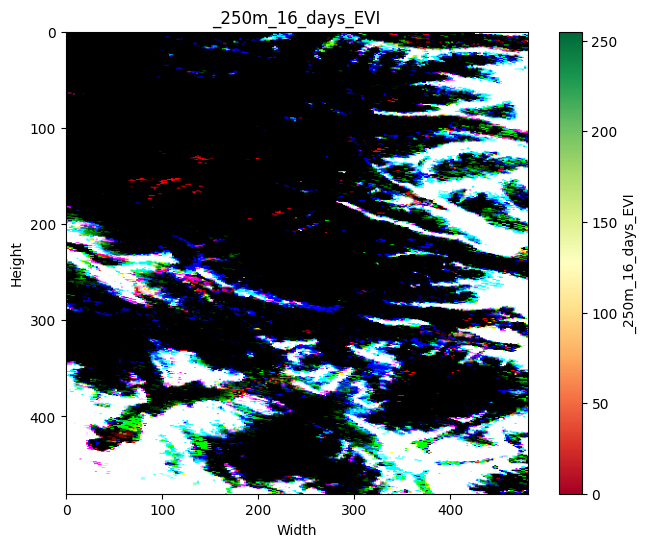

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3000..9994].


Band _250m_16_days_NDVI: Type=Int16, Min=-1999.0, Max=9994.0, Mean=282.88035388973, StdDev=2593.9377588332
Band Projection : GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]



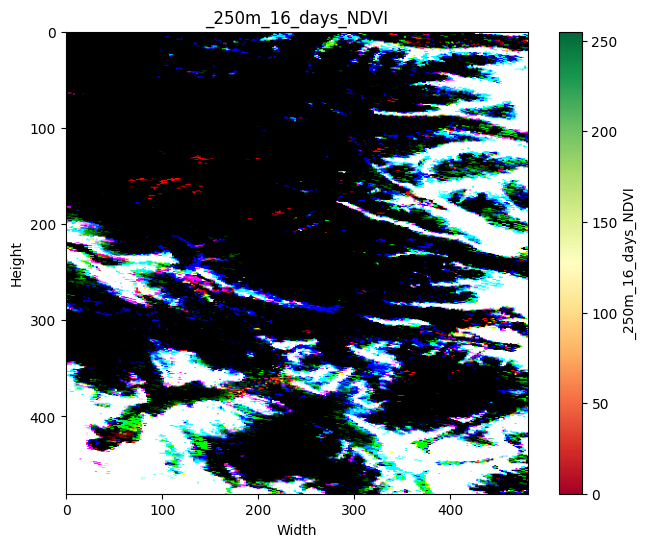

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [14..65535].


Band _250m_16_days_VI_Quality: Type=Int32, Min=274.0, Max=55615.0, Mean=13251.348438718, StdDev=12843.969397125
Band Projection : GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]



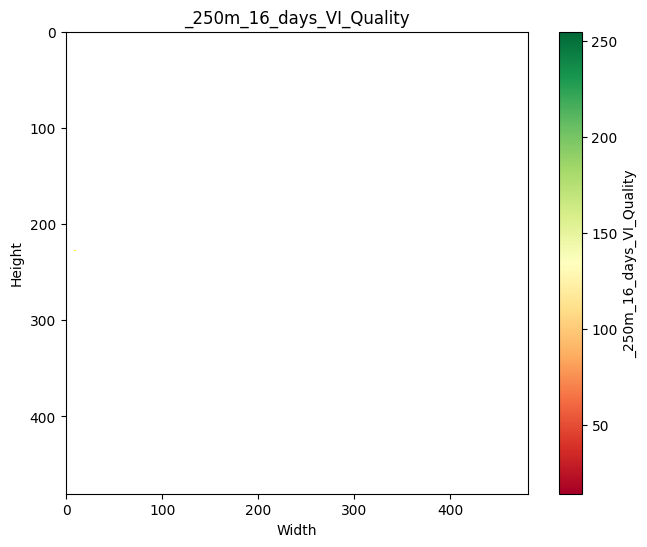

In [75]:
features_ds = gdal.Open(str((features_dir / 'MOD13Q1.061_250m_aid0001.nc').resolve()))
features_proj = features_ds.GetProjection()

for subdataset in features_ds.GetSubDatasets():
    band_ds = gdal.Open(subdataset[0])
    band = band_ds.GetRasterBand(1)
    band_type = gdal.GetDataTypeName(band.DataType)
    band_min, band_max, band_mean, band_stddev = band.GetStatistics(True, True)
    band_desc = band_ds.GetDescription().split(':')[-1]
    print(f"Band {band_desc}: Type={band_type}, Min={band_min}, Max={band_max}, Mean={band_mean}, StdDev={band_stddev}")
    print(f"Band Projection : {band_ds.GetProjection()}")
    print("")
    

    band_data = band_ds.ReadAsArray()

    plt.figure(figsize=(8, 6))
    plt.imshow(band_data.transpose((1, 2, 0)), cmap='RdYlGn')
    plt.colorbar(label=band_desc)
    plt.title(band_desc)
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.show()

# Download Target

In [3]:
target_dir = Path('data/target/')

In [69]:
nbac_response = requests.get("https://cwfis.cfs.nrcan.gc.ca/downloads/nbac/nbac_1972_2023_20240530_shp.zip")
zipfile.ZipFile(io.BytesIO(nbac_response.content)).extractall(target_dir)

In [4]:
target_shp = list(target_dir.glob('*.shp'))[0]
target_shp

PosixPath('data/target/nbac_1972_2023_20240530.shp')

# Preview Target

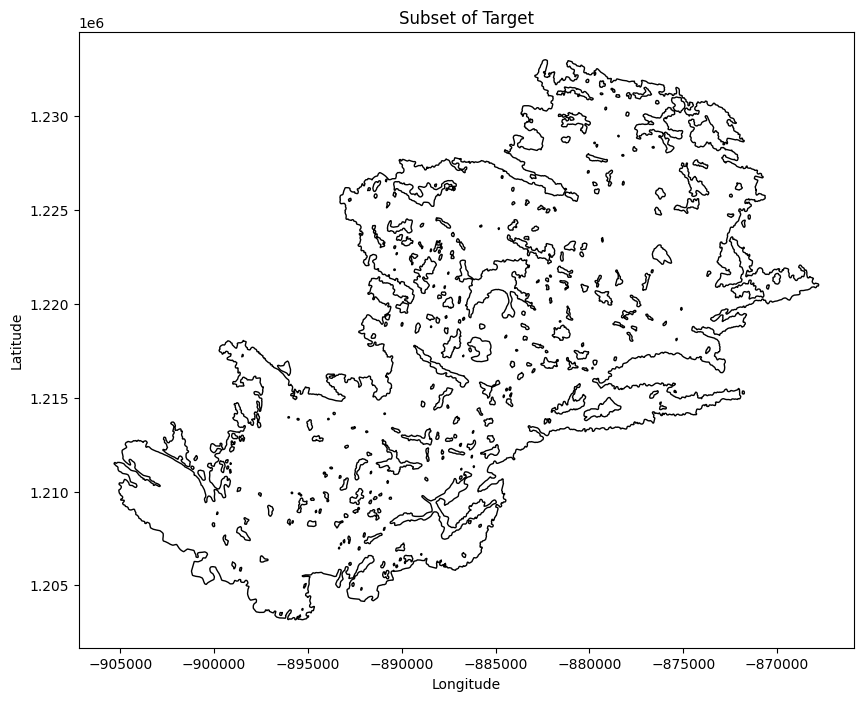

In [21]:
gdf = gpd.read_file(target_shp, rows=1)

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, edgecolor='k', facecolor='none')
plt.title('Subset of Target')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Reproject Target

In [5]:
reprojected_target_shp = Path(target_shp.parent, f"{target_shp.stem}_reprojected.shp")

In [ ]:
gdal.VectorTranslate(
    str(reprojected_target_shp.resolve()), 
    str(target_shp.resolve()), 
    dstSRS='EPSG:4326',
    reproject=True
)

# Preview Target

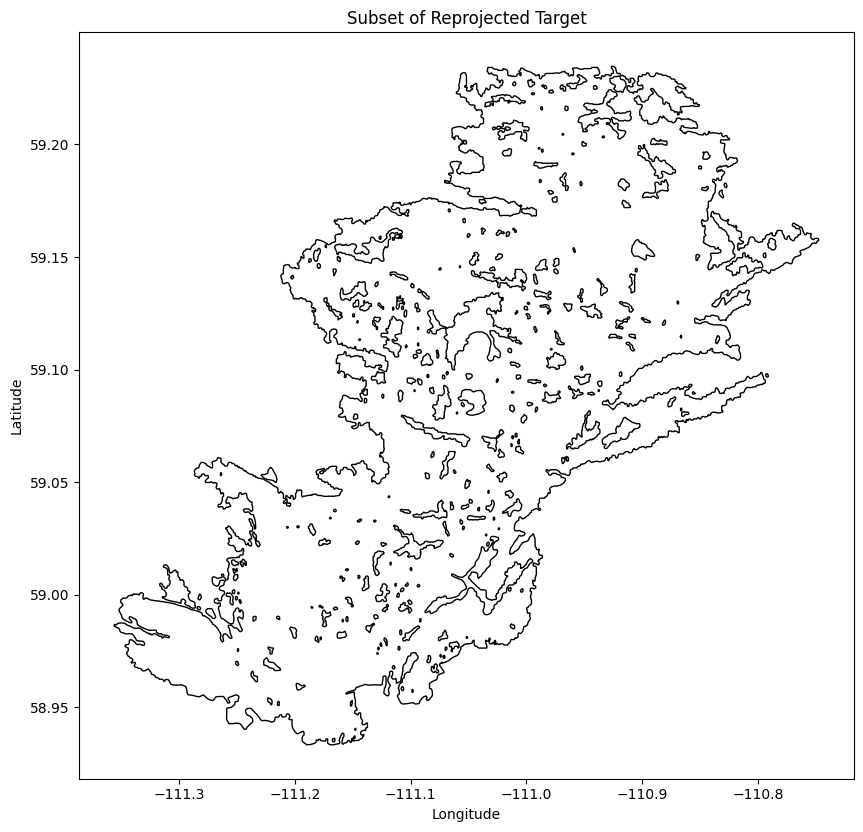

In [22]:
gdf = gpd.read_file(reprojected_target_shp, rows=1)

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, edgecolor='k', facecolor='none')
plt.title('Subset of Reprojected Target')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()